# Выбор локации для скважины

Целью проекта является предсказание прибыли и риска добычи  нефти в трёх регионах, в каждом 10 000 месторождений. Бюджет на разработку скважин в регионе — 10 млрд рублей. Нужно выбрать 200 скважин. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Характеристики для каждой скважины в регионе известны (представленны как синтетические данные f0, f1, f2). 

Результатом работы стала модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализирована прибыль и риски техникой Bootstrap.

## Загрузка и подготовка данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
import random
import scipy.stats as st
from sklearn.metrics import mean_squared_error, r2_score
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy.random import RandomState

In [3]:
warnings.filterwarnings('ignore')
sns.set()
sns.set_style("whitegrid")

Загрузим датасет

In [4]:
d0 = pd.read_csv('geo_data_0.csv')
d0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
d0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
d0['id'] = d0['id'].str.lower()
d0.duplicated().sum()

0

In [7]:
d1 = pd.read_csv('geo_data_1.csv')
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
d1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [9]:
d1['id'] = d1['id'].str.lower()
d1.duplicated().sum()

0

In [10]:
d2 = pd.read_csv('geo_data_2.csv')
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
d2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [12]:
d2['id'] = d2['id'].str.lower()
d2.duplicated().sum()

0

In [13]:
d_set = [d0,d1,d2]

Рассмотрим распределение признаков в разных регионах

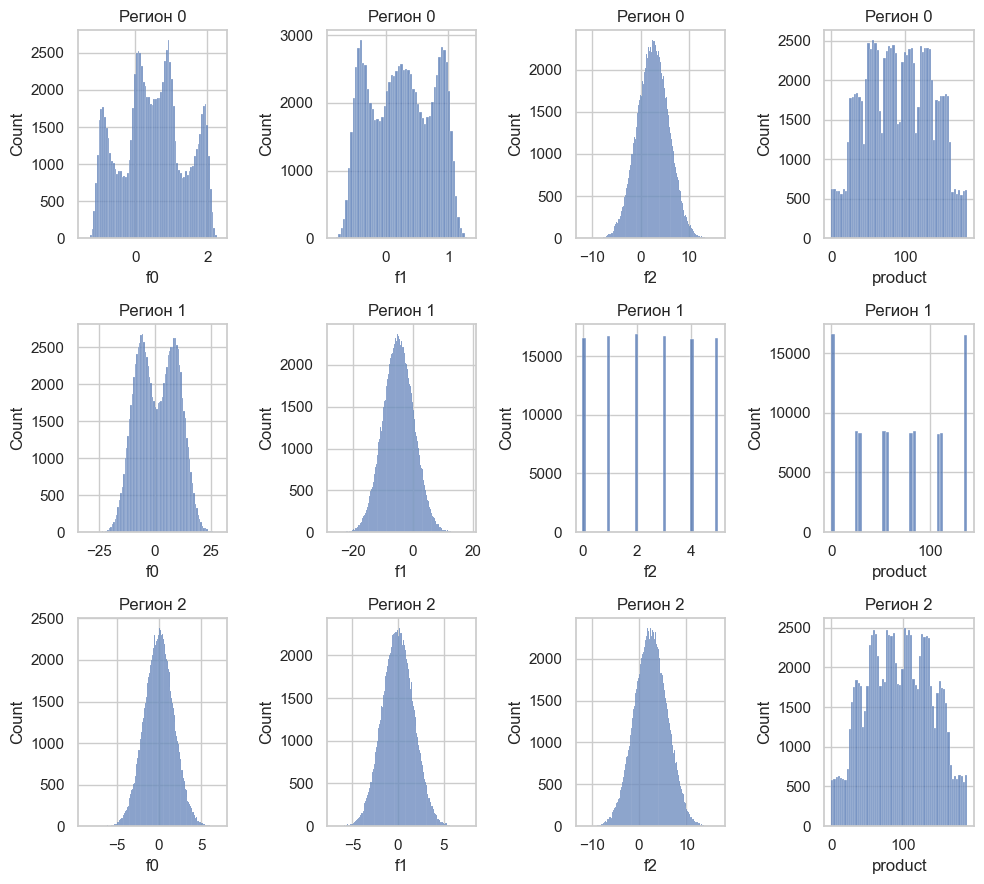

In [14]:
c = 0
fig, ax = plt.subplots(3, 4, figsize=(10, 9))
for s in d_set:
    for i in range(4):
        ax[c, i].set_title(f'Регион {c}')
        sns.histplot(s.iloc[:,1+i], ax=ax[c,i])
    c += 1
plt.tight_layout()

**Выводы: проверка датасетов показала, что синтетические данные подготовлены хорошо без пропусков и дубликатов. Поведение признаков сильно отличаются в разных регионах, особенно во 2 регионе где распределение дискретное.**

## Обучение и проверка модели

*Разобьем данные на  features и target для обучения и валидации. Но сначала закодируем столбец 'id'*

In [15]:
features_valid, features_train, target_valid, target_train = [],[],[],[]

In [16]:
for i in range(len(d_set)):
    f = d_set[i].drop(['product','id'], axis=1)
    t = d_set[i]['product']
    f_train, f_valid, t_train, t_valid = train_test_split(f,
                                                          t,
                                                          test_size=.25,
                                                          random_state=123,
                                                         )
    features_valid.append(f_valid)
    features_train.append(f_train)
    target_valid.append(t_valid)
    target_train.append(t_train)

*Проверим как коррелируют признаки*

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


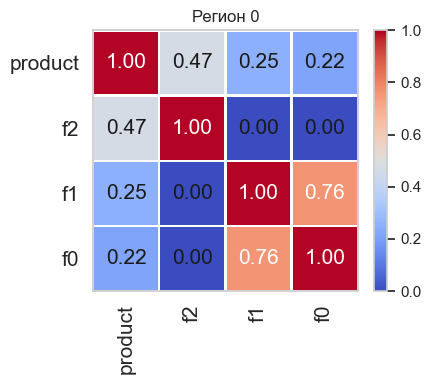

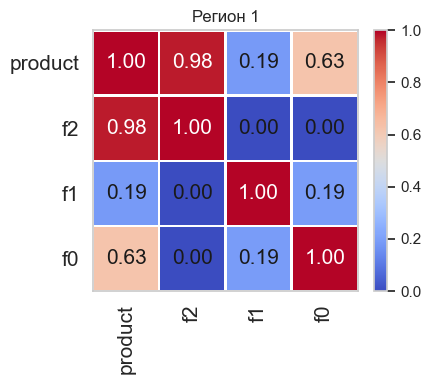

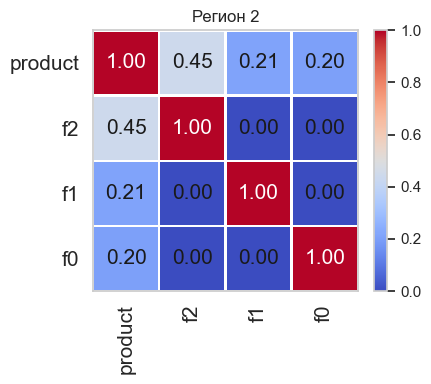

In [17]:
for i in range(3):
    phik_overview = pd.concat([features_train[i],target_train[i]],axis=1).phik_matrix()
    plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        title=r"correlation $\phi_K$", 
                        color_map="coolwarm",
                        fontsize_factor=1.5, 
                        figsize=(4.5, 4))
    plt.title(f'Регион {i}')
    plt.tight_layout()

*Признаки не коррелируюnт между собой, за ичключением региона 0, в котором есть корреляция между f0 и f1*

In [18]:
for s in features_train:
    print(s.shape)
for s in features_valid:
    print(s.shape)
for s in target_train:
    print(s.shape)
for s in target_valid:
    print(s.shape)

(75000, 3)
(75000, 3)
(75000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(75000,)
(75000,)
(75000,)
(25000,)
(25000,)
(25000,)


Обучим модель **линейной регресси** для регионов, раcсчитаем среднее значение количества баррелей в скважине и RMSE

In [19]:
model = LinearRegression()
target_predict = []
for i in range(3):
    model.fit(features_train[i],target_train[i])
    target_predict.append(model.predict(features_valid[i]))

In [20]:
i = 0
print('Среднее значение, тыс.барр')
for s in target_predict:
    print(f"Регион {i}")
    print(round(s.mean()))
    i += 1

Среднее значение, тыс.барр
Регион 0
93
Регион 1
69
Регион 2
95


In [21]:
print('RSME')
for i in range(3):
    print(f"Регион {i}")
    mse = mean_squared_error(target_valid[i],target_predict[i])
    print(round(mse**.5))

RSME
Регион 0
38
Регион 1
1
Регион 2
40


In [22]:
print('Коэффициент детерминации')
for i in range(3):
    print(f"Регион {i}")
    r2 = r2_score(target_valid[i],target_predict[i])
    print(round(r2,2))

Коэффициент детерминации
Регион 0
0.28
Регион 1
1.0
Регион 2
0.19


**Вывод: Регионы 0 и 2 показали схожие результаты: срежнее около 93-95, RMSE  ~40 и даже показатель модели. Регион 1 показал значительно худший результат - 69 тыс.бар., но его модель значительно точнее предсказывается.** 

## Подготовка к расчёту прибыли

*Расчитаем сколько должна приносить одна скважина для безубыточного производства*

*Бюджет на разработку скважин в регионе — 10 млрд рублей. Нужно выбрать 200 скважин. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.*

*Средняя стоимость разработки следовательно равна*

In [23]:
budget = 10*10**9
count_oilwell = 200

In [42]:
needed_value = budget / count_oilwell
print(f'Средняя соимость разработки скважины - {needed_value / 10**6} мил.р.')

Средняя соимость разработки скважины - 50.0 мил.р.


*Чтобы скважина окупилось в ней должно быть следующее количество нефти*

In [43]:
income_per_barrel = 450
min_value = round(needed_value / income_per_barrel / 10 **3)
print(f'Необходимый запас нефти в скважине, тыс.бар - {min_value}')

Необходимый запас нефти в скважине, тыс.бар - 111


*Обратим внимание, что средний запас нефти значительно ниже в скважине в любом регионе. Поэтому отберем лучшие 200 скважин*

## Расчёт прибыли и рисков 

*Преобразуем список предсказанных значений в Серию*

In [26]:
target_predicted = []
for i in range(3):
    target_predicted.append(pd.Series(target_predict[i], index=target_valid[i].index))

*Найдем суммарное количество нефти в 200 лучших скважинах и доход от них, а также средние величины*

In [44]:
for i in range(3):
    l = target_predicted[i].sort_values(ascending=False)[:200]
    print(f'Регион {i}')
    print(f'Суммарный запас нефти, тыс.барю - {l.sum()}')
    print(f'Суммарная прибыль, милр.р. - {l.sum()  * income_per_barrel / 10**6 - 10}')
    print(f'Средний запас в скважине, тыс.бар {l.mean()}')
    print(f'Средний доход, мил.р. {l.mean() * income_per_barrel / 10**3 - 50}')
    print('- - - - - -')

Регион 0
Суммарный запас нефти, тыс.барю - 31034.787805093565
Суммарная прибыль, милр.р. - 3.9656545122921045
Средний запас в скважине, тыс.бар 155.17393902546783
Средний доход, мил.р. 19.828272561460523
- - - - - -
Регион 1
Суммарный запас нефти, тыс.барю - 27755.761982793923
Суммарная прибыль, милр.р. - 2.490092892257266
Средний запас в скважине, тыс.бар 138.7788099139696
Средний доход, мил.р. 12.45046446128633
- - - - - -
Регион 2
Суммарный запас нефти, тыс.барю - 29943.443110391785
Суммарная прибыль, милр.р. - 3.4745493996763024
Средний запас в скважине, тыс.бар 149.71721555195893
Средний доход, мил.р. 17.37274699838153
- - - - - -


In [28]:
target_predicted_98 = []
for i in range(3):
    treshold = target_predicted[i].quantile(q=0.98)
    target_predicted_98.append(target_predicted[i].loc[lambda x: x < treshold])

In [29]:
def profit_200(target, probabilities,income_oilwell=450*10**3,budget=10**10,count=200):
    """
    Функция возвращает прибыль 200 лучших скважин
    """
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return income_oilwell * selected.sum() - budget

In [30]:
state = np.random.RandomState(123)

In [31]:
def bootstrap_profit(target,predictions):
    """
    Возвращает среднюю прибыль, 95% доверительный интервал и вероятность убытка
    """
    revenue = []
    target = target[predictions.index] 
    for i in range(2000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit_200(target_sample,predictions_sample)) 
    mean_revenue = round(sum(revenue) / len(revenue), 2)    
    lower = round(np.percentile(revenue, 2.5), 2)
    higher = round(np.percentile(revenue, 97.5), 2)
    risk = round(st.percentileofscore(revenue, 0), 2)

    return (mean_revenue, (lower, higher),  risk)

*Рассчитаем потенциальную прибыль для каждого региона*

In [32]:
c = 0
for target, prediction in zip(target_valid, target_predicted):
    mean_revenue, interval,  risk = bootstrap_profit(target,prediction)
    print(f'Регион {c}')
    print(f'Средняя прибыль - {round(mean_revenue / 10**9,3)}')
    print(f'Доверительный интервал - от {round(interval[0] / 10**9,3)} до {round(interval[1] / 10**9,3)}')
    print(f'Вероятность убытка - {risk}')
    c += 1

Регион 0
Средняя прибыль - 0.507
Доверительный интервал - от -0.024 до 1.037
Вероятность убытка - 3.2
Регион 1
Средняя прибыль - 0.519
Доверительный интервал - от 0.095 до 0.973
Вероятность убытка - 0.7
Регион 2
Средняя прибыль - 0.366
Доверительный интервал - от -0.192 до 0.927
Вероятность убытка - 10.0


**Вывод: бутсрап показал, что наиболее надежным регионом является регион 1. Средняя прибыль региона равна 0,5 млрд.р. при низком риске прогореть не более 1%. Так же 95% доверительный интервал лежит в положительной части от 0.099 до 0.956 млрд., что показывает надежность региона. Самым рискованным регионом является регион 2, риск прогореть около 10%, при потенциальной прибыли 0,3 млрд.**